In [99]:
import torch
import itertools
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Reconstruct the model
def model_builder(N, m, k, nonlinearity):
    if nonlinearity == 'ReLU':
        activation = nn.ReLU()
    elif nonlinearity == 'GeLU':
        activation = nn.GELU()
    elif nonlinearity == 'SoLU':
        activation = lambda x: x*torch.exp(x)    
    
    model = torch.nn.Sequential(
                nn.Linear(m, k, bias=True),
                activation,
                nn.Linear(k, N, bias=False)
            )
    return model

In [86]:
def sample_vectors_equal(N: int, eps: float, batch_size: int, embedder):
    """
        Generates random uniform vectors in a tensor of shape (N,batch_size)
        with sparsity 1-eps. These are returned as v.

        Applies embedding matrix to v to produce a low-dimensional embedding,
        returned as x.
    """

    v = torch.rand((int(batch_size), int(N)))
    
    compare = eps * torch.ones((int(batch_size), int(N)))
    sparsity = torch.bernoulli(compare)
            
    v *= sparsity
    x = torch.matmul(v,embedder.T) # Embeds features in a low-dimensional space

    return v, x

In [3]:
model = 'model3'
k = 1024 # size of nonlinear layer
log2_batch_size = 13
log2_training_steps = 18
sample_kind = 'equal'
init_bias = 0.0
nonlinearity = 'ReLU'
task = 'autoencoder'
decay = 0.0
eps = 0.015625
m = 64 # input dimensions
N = 512 # number of features
reg = 0.0
lr = 0.03

In [4]:
fname = f"../my_models/{model}_{task}_{nonlinearity}_k_{k}_batch_{log2_batch_size}_steps_{log2_training_steps}_learning_rate_{lr}_sample_{sample_kind}_init_bias_{init_bias}_decay_{decay}_eps_{eps}_m_{m}_N_{N}_reg_{reg}.pt"

In [5]:
batch = torch.load(fname, map_location=torch.device('cpu'))

In [6]:
batch.keys()

dict_keys(['k', 'log2_batch_size', 'log2_training_steps', 'learning_rate', 'sample_kind', 'initial_bias', 'nonlinearity', 'losses', 'final_model', 'log2_spaced_models', 'setup', 'task', 'decay', 'eps', 'm', 'N', 'reg'])

In [7]:
d = batch['log2_spaced_models'][-1]
print(d['2.weight'].shape[0], N)
print(d['0.weight'].shape[1], m)
print(d['0.weight'].shape[0], k)
model = model_builder(d['2.weight'].shape[0], d['0.weight'].shape[1], d['0.weight'].shape[0], nonlinearity)
model.load_state_dict(batch['log2_spaced_models'][-1])
model.to('cpu')

512 512
64 64
1024 1024


Sequential(
  (0): Linear(in_features=64, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=False)
)

In [8]:
fixed_embedder = batch['setup']['fixed_embedder']

In [9]:
vs = torch.eye(N)
ins = torch.matmul(vs, fixed_embedder.T)
sfa = model[:2].forward(ins).T.detach().numpy()

In [10]:
k

1024

In [11]:
# Sort the neurons to put the most-monosemantic first
inds = np.argsort(-np.amax(sfa,axis=1) / (1e-10 + np.mean(sfa,axis=1)))
sfa = sfa[inds]

# Sort the features to put the most-monosemantic neurons first
neuron_inds = []
for i in range(sfa.shape[1]): # Loop over features
    neuron_ind = np.argmax(sfa[:,i]) # Find the neuron this feature activates most-strongly.
    neuron_inds.append(neuron_ind)
inds = np.argsort(neuron_inds) # Sort the neuron indices
sfa = sfa[:,inds]

In [12]:
sfa.shape

(1024, 512)

In [13]:
k

1024

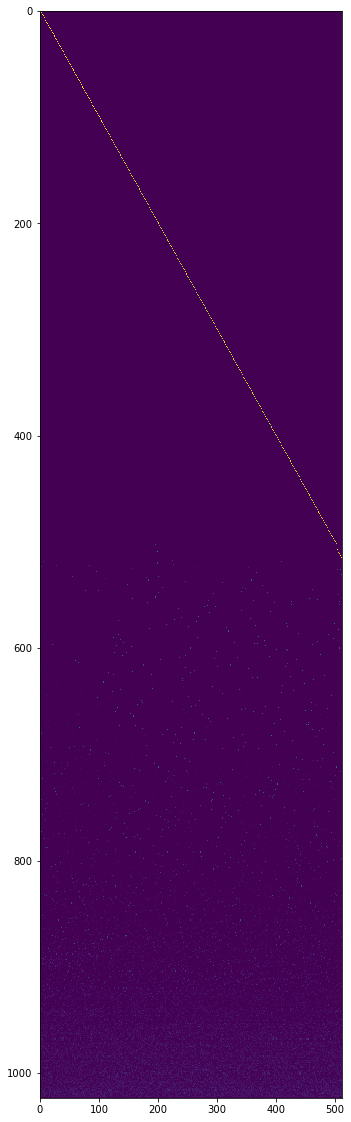

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(sfa,interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)

In [15]:
np.max(sfa)

1.1253219

# soft dot

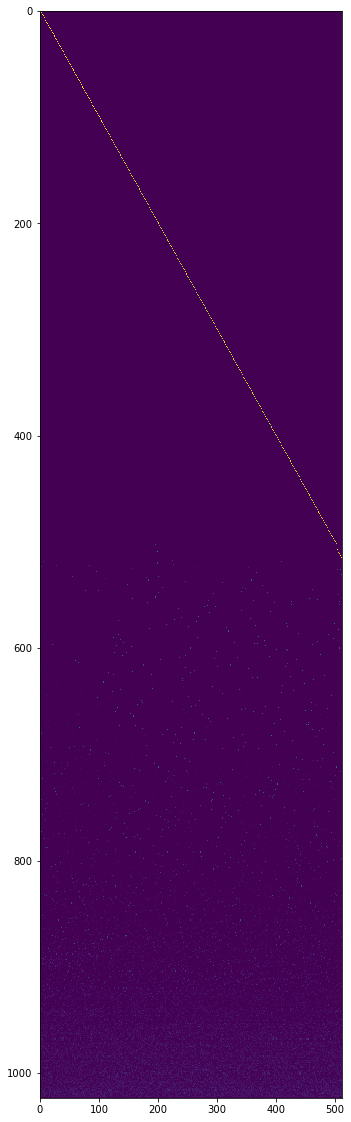

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(sfa,interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)

In [17]:
dot = np.dot(sfa, sfa.T)

In [18]:
dot.shape

(1024, 1024)

$a$ is matrix of shape n neurons (k) by n features (N) (1024-by-512). 

Each row is a vector of the activations for that feature.

$a \cdot a^{T} = \sum^{k}_{i} \sum^{k}_{j} a_{i}a_{j}$

The diagonal of $a \cdot a^{T}$ i.e. when $j=i$ is a measure of similarity between a neruons activation vector and itself  



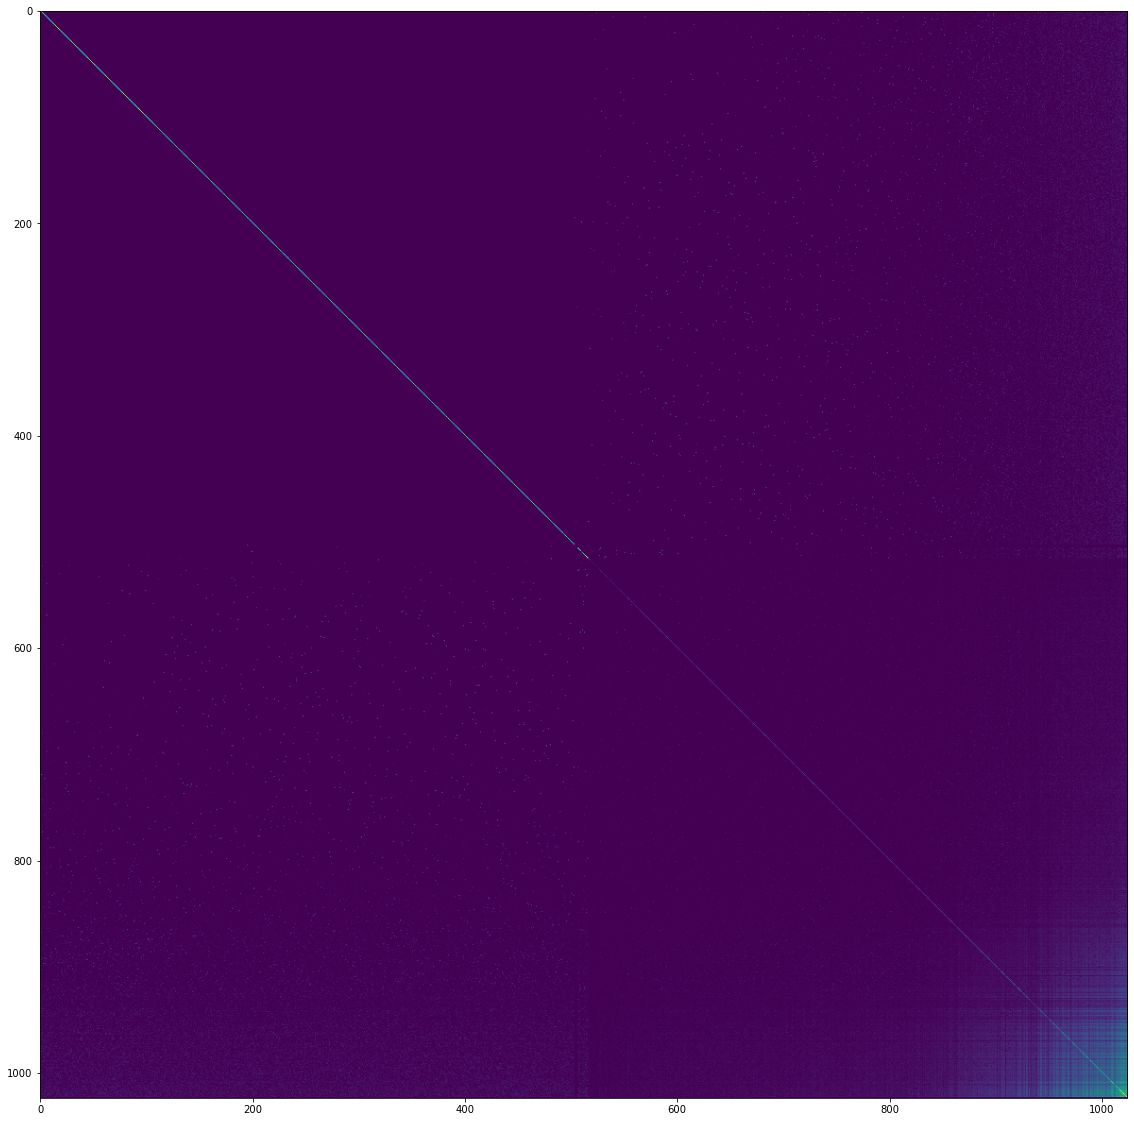

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(dot)

In [20]:
np.diagonal(dot)

array([1.0035623, 1.046783 , 1.0021054, ..., 1.0918279, 1.2739553,
       0.       ], dtype=float32)

In [21]:
np.sum(np.diagonal(dot))

597.08276

In [22]:
print(np.sum(dot))
print(np.sum(dot)/(N*N))
print((np.sum(dot) - np.sum(np.diagonal(dot))) / (N*N))

9128.545
0.03482263535261154
0.03254494443535805


In [23]:
(np.sum(np.tril(dot)) - np.sum(np.diagonal(dot))) / (N * (N - 1))

0.01630431471972083

In [24]:
np.tril(dot, -1)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00296463, 0.03238404, ..., 0.        , 0.        ,
        0.        ],
       [0.07174861, 0.02634282, 0.04663249, ..., 0.806724  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [25]:
np.sum(np.tril(np.eye(k)))

1024.0

In [26]:
np.sum(np.tril(np.eye(k), -1))

0.0

In [27]:
np.tril(dot)

array([[1.0035623 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.046783  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.0021054 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00296463, 0.03238404, ..., 1.0918279 , 0.        ,
        0.        ],
       [0.07174861, 0.02634282, 0.04663249, ..., 0.806724  , 1.2739553 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [28]:
np.sum(np.tril(dot))

4862.813

In [29]:
np.sum(np.tril(dot, -1))

4265.73

In [30]:
np.sum(np.tril(dot, -1)) / (N * (N - 1))

0.01630431285343058

# soft dot random activation

In [87]:
vs, ins = sample_vectors_equal(N, eps, 2 ** log2_batch_size, fixed_embedder)

In [88]:
print(vs.shape, ins.shape)

torch.Size([8192, 512]) torch.Size([8192, 64])


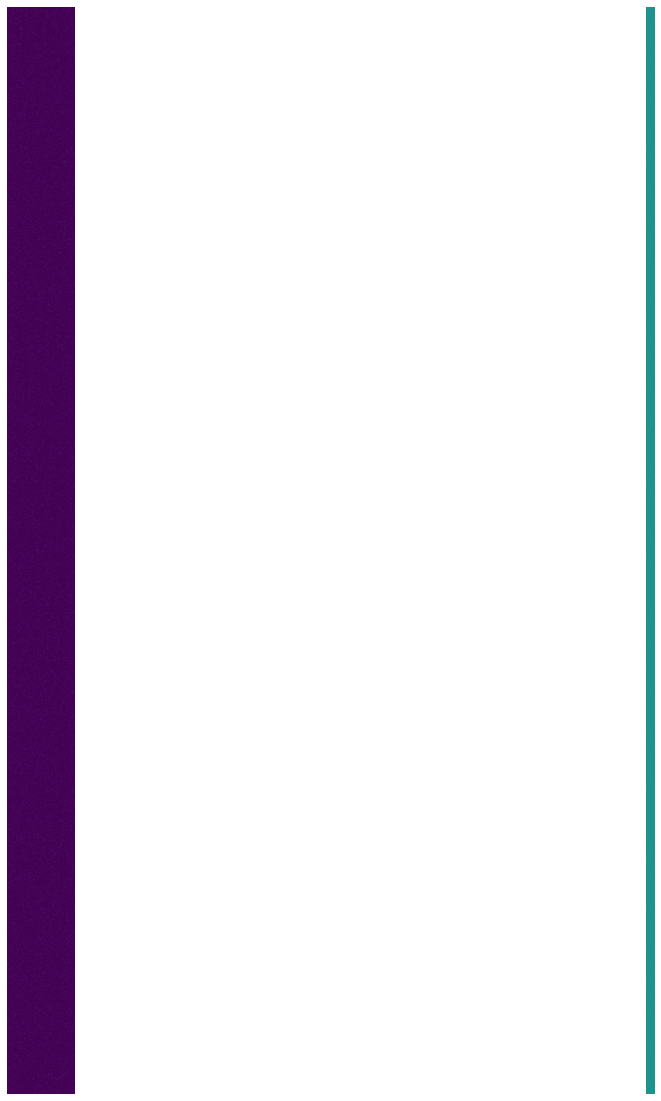

In [89]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(vs)
plt.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(ins)
plt.axis('off')
plt.show()

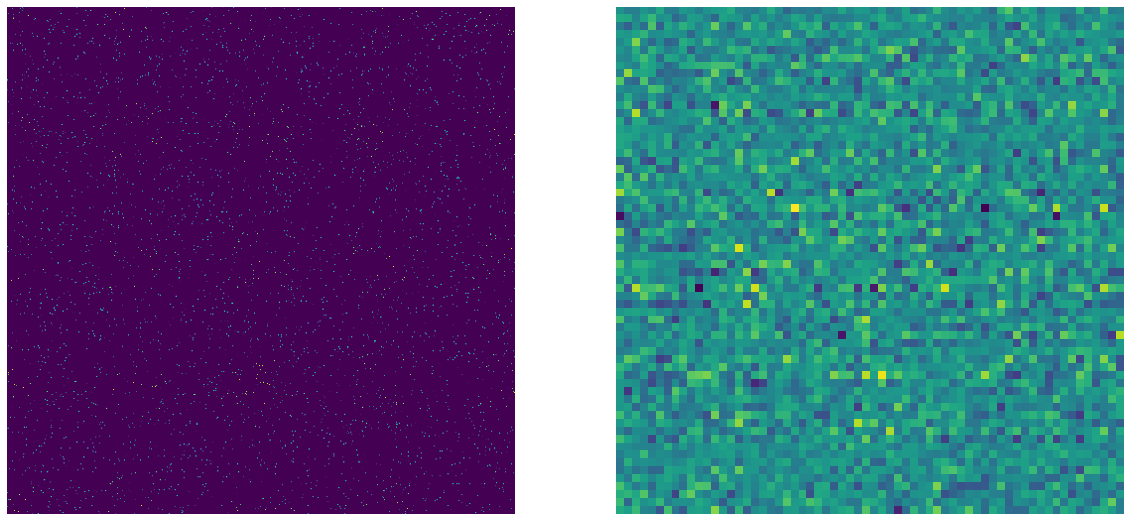

In [90]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(vs[:512])
plt.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(ins[:64])
plt.axis('off')
plt.show()

In [92]:
np.dot(ins, ins.T).shape

(8192, 8192)

Since the activation function is ReLU, if a neuron activates at all, it must activate when the feature input amplitude is one. I can therefore binarise the inputs and use those to detect polysemantic neurons. Since if a neuron activates for a feature at any input amplitude it will activate at unit input amplitude.

In [114]:
nvs = np.array(vs > 0, dtype='float32')
nins = np.array(ins > 0, dtype='float32')

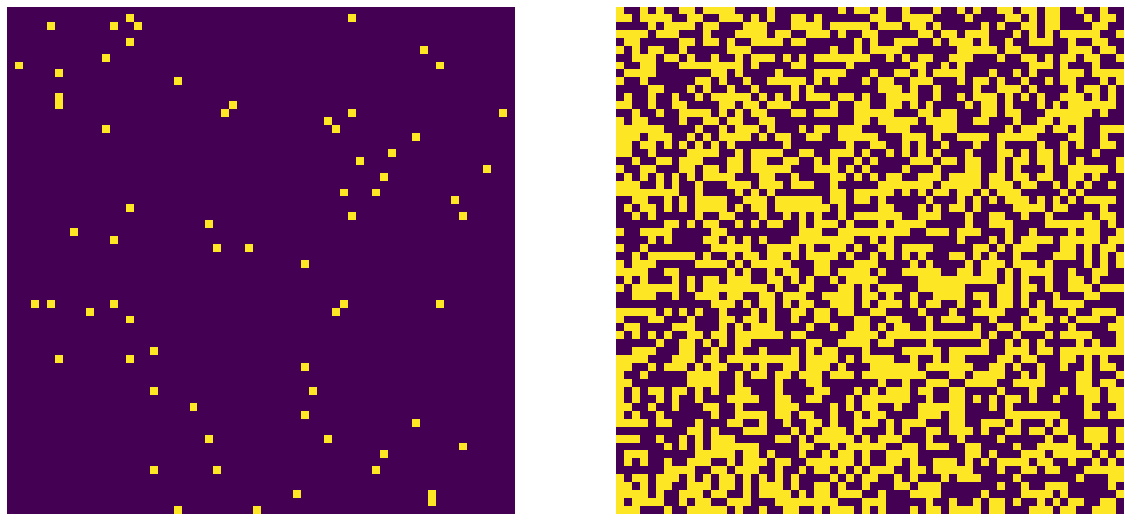

In [115]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(nvs[:64,:64])
plt.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(nins[:64])
plt.axis('off')
plt.show()

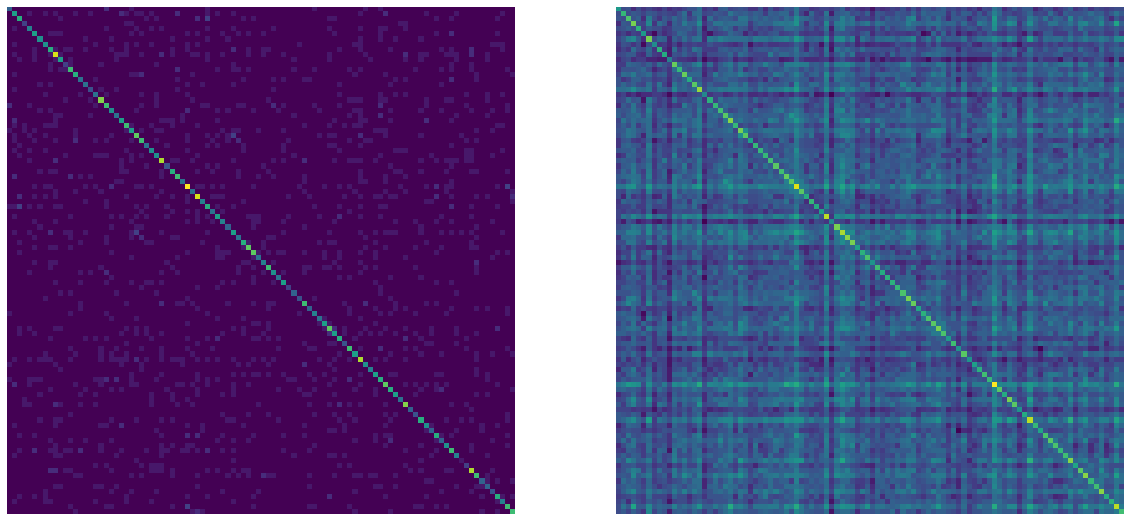

In [116]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(np.dot(nvs, nvs.T)[:100,:100])
plt.axis('off')
ax2 = fig.add_subplot(122)
ax2.imshow(np.dot(nins, nins.T)[:100,:100])
plt.axis('off')
plt.show()

The above provide a measure of how similar each input vector is to all others. They are not normalised for the number of active features per input vector since

If

$x = [0,1,0,1,0]$

$y = [0,1,0,1,0]$

then

$x \cdot y^T = 2$

and if

$x = [0,1,0,1,1]$

$y = [0,1,0,1,1]$

then

$x \cdot y^T = 3$

Should they be normalised? If these are used to weight the loss function then the unnormalised active features will upweight the significance of inputs with more active features. This seems desirable since the more active features there are the more likely we are to detect polysemantic neurons (is this correct and does this provide any benefit over treating all equally?).

Ignoring the above discussion on weighting and considering only the penalisation approach. Previously I used single feature inputs of unit amplitude. This did not penalise the case with more than one active input feature. One approach would be to randomly generate binary vectors with a range of active features and simply count the number of polysemantic neurons.

In [134]:
v = torch.rand((int(N), int(N)))

compare = torch.linspace(0,1,N) * torch.ones((int(N), int(N)))
sparsity = torch.bernoulli(compare).T
        
v *= sparsity

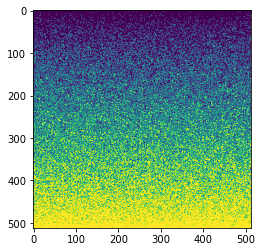

In [135]:
plt.imshow(v > 0)

The above produces an input with randomly active inputs of different sparsity. But this does not allow me to disentangle which of the active input features are activating a specific neuron. For that I still need to use the single feature inputs. 

There are perhaps two solutions:

    1. If a neuron activates for one feature given the single feature inputs, then it should be active when that same feature is active in the randomly active inputs of different sparsity. But how do we deal with the case where no neuron activates for a feature given the single feature inputs.
    2. We assign neurons to input features. An equal number of neurons are assigned to each input feature. This neurons should only activate when the feature to which they are assigned is active and should be inactive otherwise. This hard codes the number of neurons per feature. Is there a way to make this learnable?
    
    
Note: What about if a feature is active for the single feature input it should not activate when all but that feature is active?

In [137]:
inputs = torch.matmul(v, fixed_embedder.T)

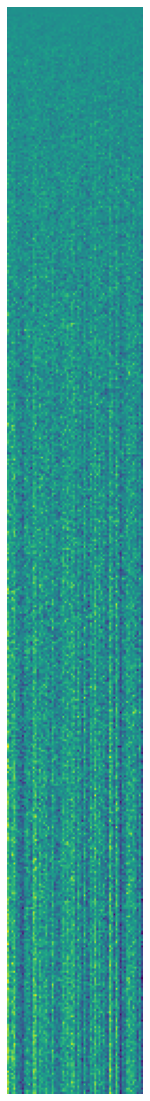

In [139]:
plt.figure(figsize=(20,20))
plt.imshow(inputs)
plt.axis('off')
plt.show()

In [144]:
acts = model[:2].forward(inputs).detach().numpy()

In [145]:
acts.shape

(512, 1024)

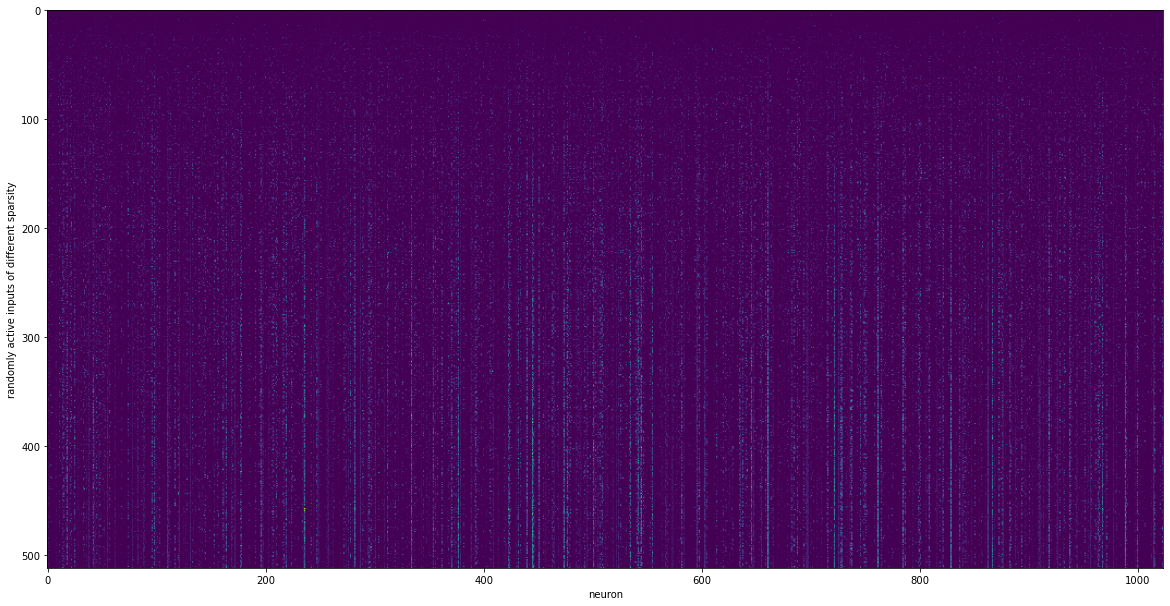

In [147]:
plt.figure(figsize=(20,20))
plt.imshow(acts)
plt.xlabel('neuron')
plt.ylabel('randomly active inputs of different sparsity')
plt.show()

In [152]:
sfa = model[:2].forward(torch.matmul(torch.eye(N), fixed_embedder.T)).detach().numpy()

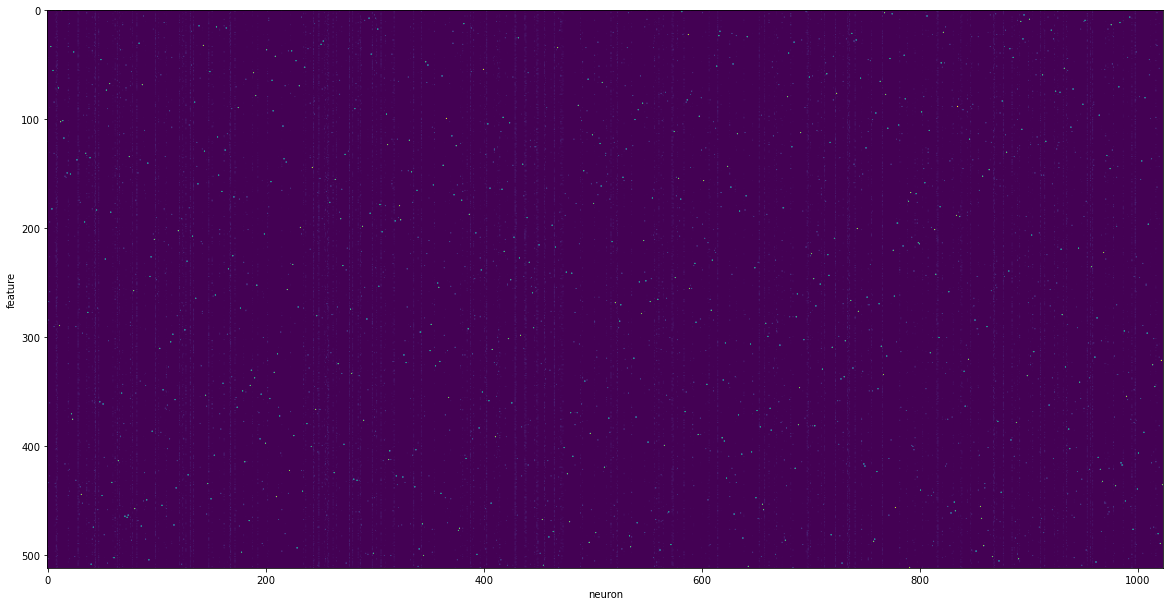

In [153]:
plt.figure(figsize=(20,20))
plt.imshow(sfa)
plt.xlabel('neuron')
plt.ylabel('feature')
plt.show()

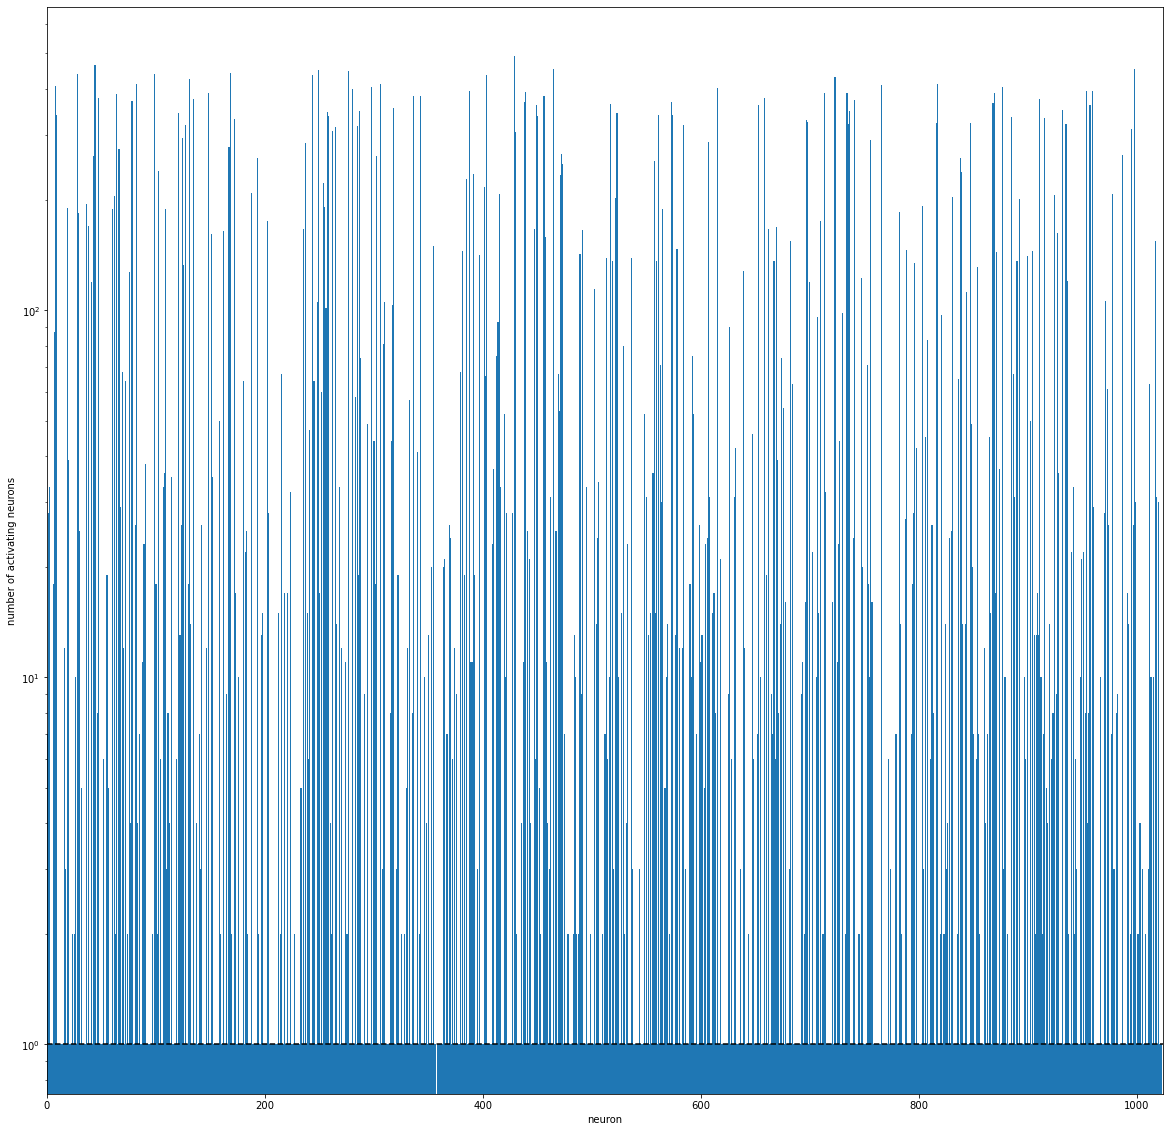

In [163]:
plt.figure(figsize=(20,20))
plt.bar(range(k), np.sum(sfa>0, axis=0), width=1)
plt.plot([0,k], [1,1], 'k--')
plt.xlabel('neuron')
plt.ylabel('number of activating neurons')
plt.xlim(0,k)
plt.yscale('log')
plt.show()

# hard dot

this won't work, I am taking the L0 norm of the activations which is not differentialable.

In [31]:
hard_sfa = np.array(sfa > 0, dtype='float')

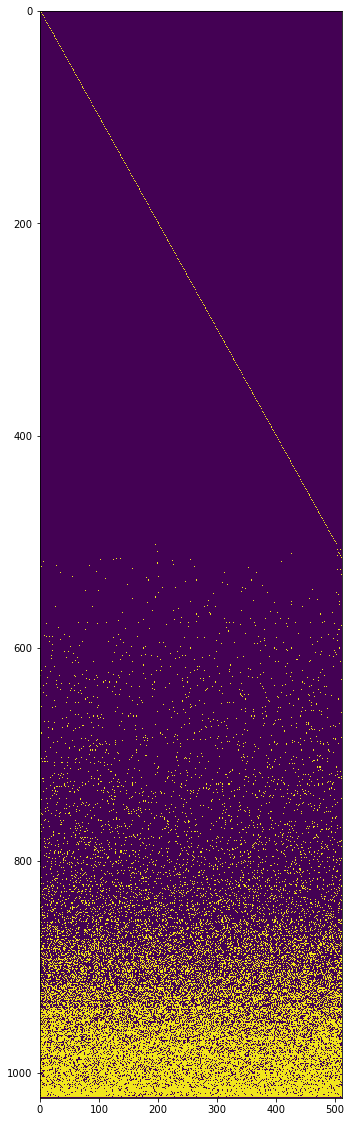

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(hard_sfa,interpolation='nearest', aspect=1.8, vmin=0, vmax=1.02)

In [33]:
hard_dot = np.dot(hard_sfa, hard_sfa.T)

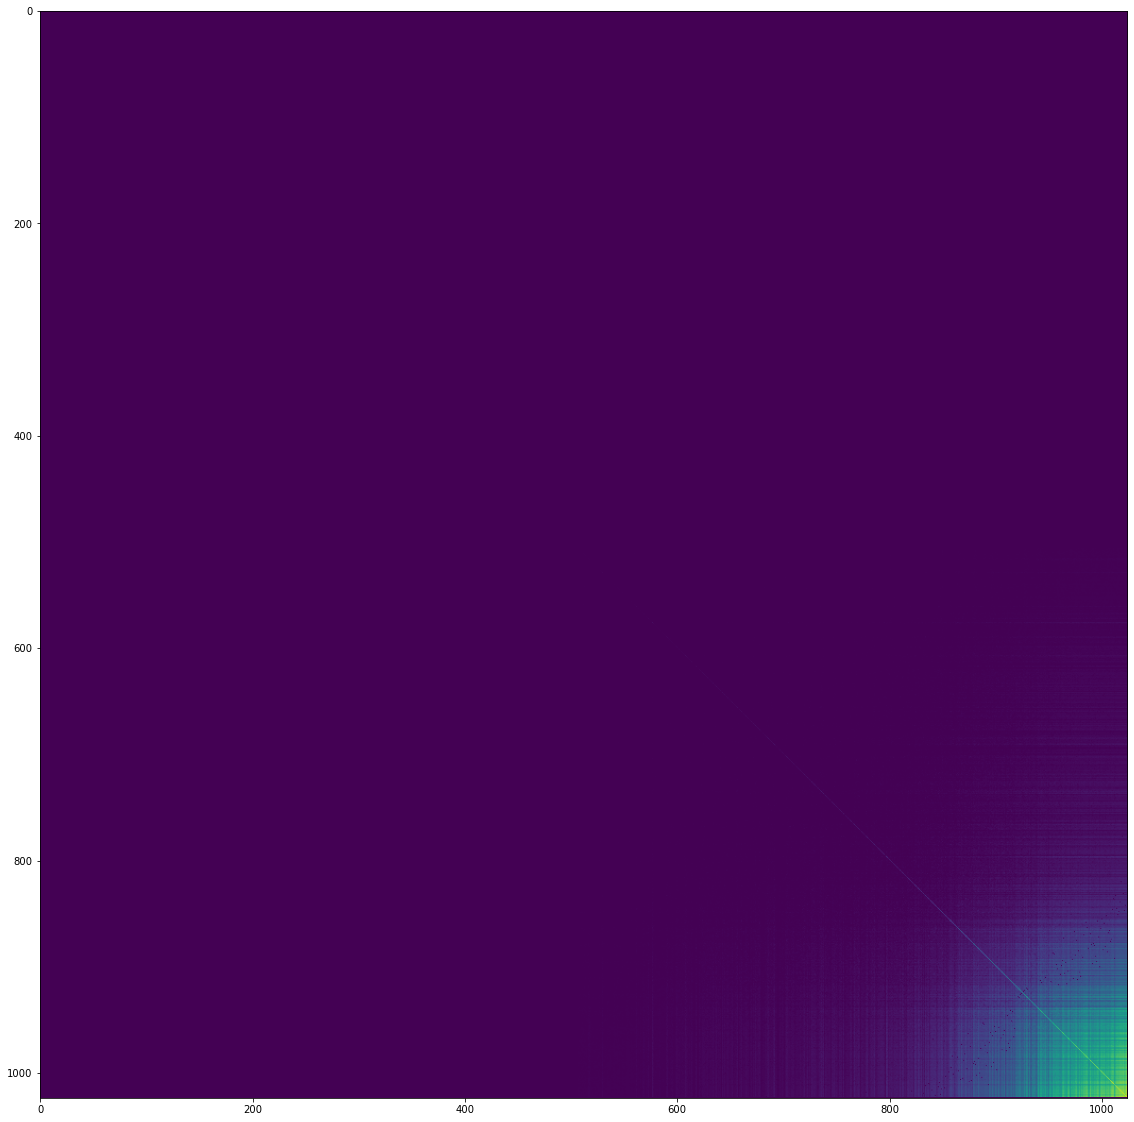

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(hard_dot)

In [35]:
np.diagonal(hard_dot)

array([  1.,   1.,   1., ..., 450., 492.,   0.])

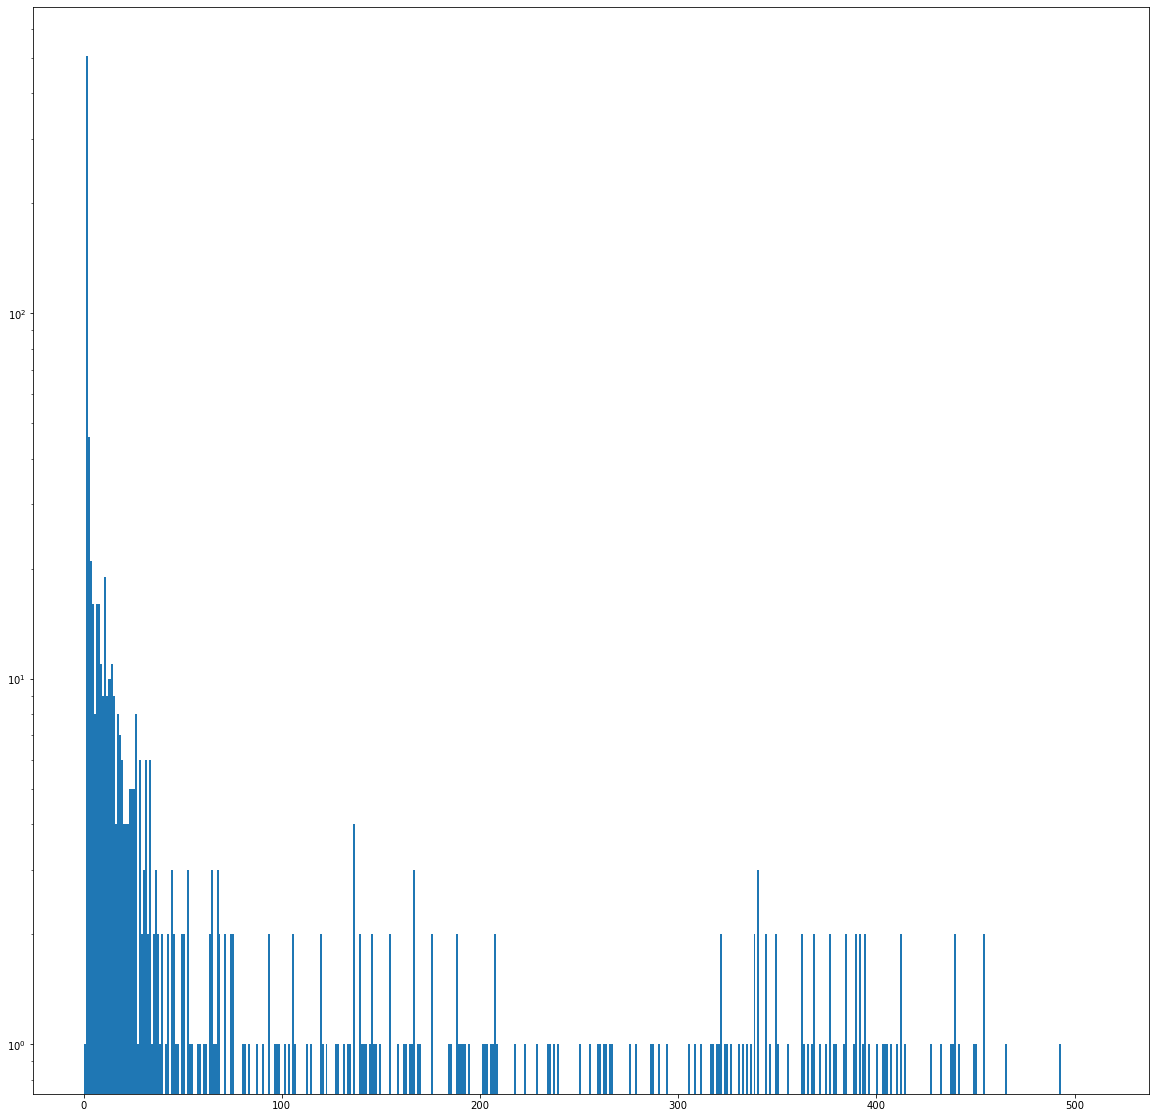

In [36]:
plt.figure(figsize=(20,20))
plt.hist(np.diagonal(hard_dot), bins=range(0,N+1,1))
plt.yscale('log')
plt.show()

In [37]:
mask = np.where(np.diagonal(hard_dot) > 1.) # > 1 rather than != 1 to ignore neurons that are "dead" and don't fire for any feature

In [38]:
(np.sum(np.diagonal(hard_dot)[mask])) / (N*k)

0.09626007080078125

# Verify numpy to torch mapping

In [39]:
import torch

In [40]:
x = np.ones((8,16))
_x = torch.ones((8,16))

In [41]:
x

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [42]:
_x

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [43]:
# np.dot(x,x)

In [44]:
np.dot(x,x.T)

array([[16., 16., 16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16., 16., 16.],
       [16., 16., 16., 16., 16., 16., 16., 16.]])

In [45]:
torch.inner(_x, _x)

tensor([[16., 16., 16., 16., 16., 16., 16., 16.],
        [16., 16., 16., 16., 16., 16., 16., 16.],
        [16., 16., 16., 16., 16., 16., 16., 16.],
        [16., 16., 16., 16., 16., 16., 16., 16.],
        [16., 16., 16., 16., 16., 16., 16., 16.],
        [16., 16., 16., 16., 16., 16., 16., 16.],
        [16., 16., 16., 16., 16., 16., 16., 16.],
        [16., 16., 16., 16., 16., 16., 16., 16.]])

# soft dot choose 2

In [46]:
c0, c1 = [], []
k = 1024
N = 512
for c in list(itertools.combinations(range(N), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [47]:
len(c0)

130816

In [48]:
_x = torch.randn((k, N))

In [49]:
torch.sum(_x, axis=0).shape

torch.Size([512])

In [50]:
torch.max(_x, axis=0)[0][:10]

tensor([3.0571, 3.5943, 3.5150, 3.0544, 3.0000, 2.9973, 3.2070, 2.8863, 3.4133,
        3.5345])

In [51]:
torch.max(_x, axis=0)[0].repeat(k,1).shape

torch.Size([1024, 512])

In [52]:
torch.max(_x, axis=0)[0].repeat(N,1)

tensor([[3.0571, 3.5943, 3.5150,  ..., 3.0663, 3.2981, 3.0746],
        [3.0571, 3.5943, 3.5150,  ..., 3.0663, 3.2981, 3.0746],
        [3.0571, 3.5943, 3.5150,  ..., 3.0663, 3.2981, 3.0746],
        ...,
        [3.0571, 3.5943, 3.5150,  ..., 3.0663, 3.2981, 3.0746],
        [3.0571, 3.5943, 3.5150,  ..., 3.0663, 3.2981, 3.0746],
        [3.0571, 3.5943, 3.5150,  ..., 3.0663, 3.2981, 3.0746]])

In [53]:
_x = _x / torch.max(_x, axis=0)[0].repeat(k, 1)

In [54]:
_x[:10]

tensor([[-0.5977,  0.6722, -0.1498,  ..., -0.5962,  0.2756,  0.0021],
        [-0.8098, -0.0834, -0.3445,  ..., -0.2692,  0.3337,  0.3766],
        [ 0.2510, -0.5316, -0.0669,  ..., -0.1403,  0.1879, -0.1671],
        ...,
        [-0.3671,  0.0332,  0.0849,  ..., -0.3491, -0.1663, -0.2018],
        [ 0.1196, -0.2278,  0.0201,  ...,  0.1976,  0.1866,  0.1971],
        [-0.3825,  0.1753, -0.0581,  ..., -0.2797,  0.0514,  0.3602]])

In [55]:
torch.sum(_x, axis=0).shape

torch.Size([512])

In [56]:
torch.sum(_x, axis=0)

tensor([ 1.1115e+01, -1.2265e+01, -6.1735e+00,  1.0544e+01, -6.0619e-02,
        -1.2275e+01,  1.3516e+01, -1.3062e+00, -1.5700e+00,  6.7893e+00,
        -5.6278e+00,  3.4545e+00, -1.1275e+01,  5.3697e+00,  7.0425e+00,
         7.8684e+00, -1.3430e+01,  8.8610e+00,  1.8374e+00, -2.4965e+00,
         5.9329e+00, -2.6066e+01,  1.2626e+01, -7.0410e+00, -2.8881e+00,
        -7.0481e-01, -1.8167e+01, -3.1085e+00, -1.3918e+01, -2.9835e-01,
        -4.7299e+00,  7.6614e+00, -2.6459e+01,  7.4596e+00,  9.1890e+00,
        -7.4085e+00, -7.7647e+00,  2.2081e+00, -5.0488e+00,  2.7842e+01,
         1.1878e+01, -1.2542e+01,  1.3207e+01,  1.1206e+01, -1.1552e+00,
        -2.1156e+00, -5.0170e+00, -5.2928e+00,  3.0277e+00, -2.2683e+00,
        -6.4581e+00,  3.9494e+00,  1.2613e+01,  1.5462e+01,  5.6893e+00,
         8.9195e+00, -1.7368e+00,  1.5836e+01,  2.6819e+00, -1.2121e+01,
         2.4126e+00, -1.6129e+01, -9.5175e+00,  1.2494e+01,  1.7976e+00,
         4.6272e+00,  2.3911e+00,  3.2346e+00, -1.8

In [57]:
_x[:,c0].shape

torch.Size([1024, 130816])

In [58]:
# a = (_x[:,c0] - _x[:,c1]) * (_x[:,c0] - _x[:,c1])

In [59]:
a = torch.inner(_x[:,c0], _x[:,c1])

In [60]:
a.shape

torch.Size([1024, 1024])

In [61]:
a[:10]

tensor([[  0.1752, -34.1959,  27.5573,  ...,  10.5487, -46.2297,  -4.6645],
        [-52.7255,  50.5467, -40.2589,  ..., -40.2040,  32.3800,  23.0539],
        [ 36.7575, -77.2056,  17.7760,  ...,  33.7803, -16.6834, -37.4179],
        ...,
        [  0.8192,  -6.8949,  39.4516,  ..., -14.0836,   2.4039,  37.1687],
        [ -6.0913,  45.6806,  -2.4324,  ..., -26.3650,  26.8202,  44.6311],
        [-18.5830,  29.5386,  -7.8778,  ...,   3.1022, -13.6227,  42.7695]])

In [62]:
b = torch.sum(a, axis=0)

In [63]:
b.shape

torch.Size([1024])

In [64]:
b[:10]

tensor([  331.4122, -1134.2158,   598.3547,  -423.8385,  -145.4599,  -861.8823,
        -2221.2046, -2592.1179,  -661.2413, -1333.1346])

In [65]:
c = torch.sqrt(b)

In [66]:
c.shape

torch.Size([1024])

In [67]:
c[:10]

tensor([18.2047,     nan, 24.4613,     nan,     nan,     nan,     nan,     nan,
            nan,     nan])

In [68]:
torch.sum(c) / len(c0)

tensor(nan)

In [69]:
_x.index_select(0, torch.tensor(c0))

tensor([[-0.5977,  0.6722, -0.1498,  ..., -0.5962,  0.2756,  0.0021],
        [-0.5977,  0.6722, -0.1498,  ..., -0.5962,  0.2756,  0.0021],
        [-0.5977,  0.6722, -0.1498,  ..., -0.5962,  0.2756,  0.0021],
        ...,
        [-0.2822,  0.0471, -0.3212,  ...,  0.2659,  0.1303, -0.5158],
        [-0.2822,  0.0471, -0.3212,  ...,  0.2659,  0.1303, -0.5158],
        [ 0.4059,  0.0928, -0.0622,  ...,  0.4912,  0.0849, -0.7640]])

In [70]:
from timeit import default_timer as timer

In [71]:
def slicex(x, y):
    return x[y]

In [72]:
t = []
for _ in range(100):
    start = timer()
    slicex(_x, c0)
    end = timer()
    t.append(end - start)
print(np.mean(t))

0.024044226639234695


In [73]:
t = []
for _ in range(100):
    start = timer()
    _x.index_select(0, torch.tensor(c0))
    end = timer()
    t.append(end - start)
print(np.mean(t))

0.02366588087999844


In [74]:
c0 = torch.tensor(c0)
c1 = torch.tensor(c1)

In [75]:
# t = []
# for _ in range(10000):
#     start = timer()
#     slicex(_x, c0)
#     end = timer()
#     t.append(end - start)
# print(np.mean(t))

In [76]:
# t = []
# for _ in range(10000):
#     start = timer()
#     _x.index_select(0, c0)
#     end = timer()
#     t.append(end - start)
# print(np.mean(t))

In [77]:
# def soft_dot_choose_2(sfa, c0, c1, N):
#     sfa = sfa / N * torch.sum(sfa, axis=-1).repeat(N, 1).T
#     a = sfa.index_select(0, c0)
#     b = sfa.index_select(0, c1)
#     r = (a - b) * (a - b)
#     r = torch.sum(r, axis=-1)
#     r = torch.sqrt(r)
#     r = torch.sum(r) / len(c0)

In [78]:
# t = []
# for _ in range(1000):
#     start = timer()
#     soft_dot_choose_2(_x, c0, c1, 512)
#     end = timer()
#     t.append(end - start)
# print(np.mean(t))

In [79]:
# def soft_dot_choose_2(sfa, c0, c1, N):
#     sfa = sfa / N * torch.sum(sfa, axis=-1).repeat(N, 1).T
#     a = sfa.index_select(0, c0)
#     b = sfa.index_select(0, c1)
#     r = (a - b) ** 2
#     r = torch.sum(r, axis=-1)
#     r = torch.sqrt(r)
#     r = torch.sum(r) / len(c0)

In [80]:
# t = []
# for _ in range(1000):
#     start = timer()
#     soft_dot_choose_2(_x, c0, c1, 512)
#     end = timer()
#     t.append(end - start)
# print(np.mean(t))

In [81]:
# def soft_dot_choose_2(sfa, c0, c1, N, n):
#     sfa = sfa / N * torch.sum(sfa, axis=-1).repeat(N, 1).T
# #     a = sfa.index_select(0, c0)
# #     b = sfa.index_select(0, c1)
#     a = sfa
#     b = sfa
#     r = torch.abs(a - b)
#     r = torch.sum(r) / n

In [82]:
n = len(c0)

In [83]:
# t = []
# for _ in range(1000):
#     start = timer()
#     soft_dot_choose_2(_x, c0, c1, 512, n)
#     end = timer()
#     t.append(end - start)
# print(np.mean(t))

In [84]:
def soft_dot_choose_2(sfa, c0, c1, N, n):
    sfa = sfa / N * torch.sum(sfa, axis=-1).repeat(N, 1).T
#     a = sfa.index_select(0, c0)
#     b = sfa.index_select(0, c1)
    print(a.shape)
    print(b.shape)
#     a = sfa
#     b = sfa
    r = torch.inner(sfa, sfa)
    print(r.shape)
    r = torch.sum(r) / n

In [85]:
t = []
for _ in range(1):
    start = timer()
    soft_dot_choose_2(_x, c0, c1, 512, n)
    end = timer()
    t.append(end - start)
print(np.mean(t))

torch.Size([1024, 1024])
torch.Size([1024])
torch.Size([1024, 1024])
0.03219681800692342
